# CREAT A MODEL OF DEVELOPING TOMATO FRUIT

##### Warning: 

- CPLEX cannot be provided on binder because of licensing issues. In the absence of CPLEX, the script will rely on GLPK to solve the model. FVA runs can hence take very long time. If interested in running FVA, we recommend that you download the scripts, download jupyter notebook, install required python libraries (see requirements.txt for list of libraries required) and run the analysis offline.

## Setup basic fruit model constraints

In [1]:
%matplotlib inline

#import library
from libsbml import readSBML
from cobra import io,flux_analysis,util
from cobra.core import Reaction,Metabolite
from IPython import display
from studyFunctions import setupMultiphaseModel
import time

#import custom library
from studyFunctions import *


#import sbml file
'''
#Generating multiphase model from core model directly
#cobra_model = io.sbml.create_cobra_model_from_sbml_file("Models/PlantCoreMetabolism_v1_2_3.xml")
#set up a 10 phase base model
cobra_model = setupMultiphaseModel(cobra_model,10,"MetabolitesToTransfer.txt")
'''
#Importing fruit model with gene associations collected from Lycocyc
cobra_model = io.sbml.create_cobra_model_from_sbml_file("Models/FruitModel.xml")
if "cplex" in util.solvers.keys():
    cobra_model.solver = "cplex"
else:
    cobra_model.solver = "glpk"


#remove free sucrose, glucose, NH4 and light uptake
for i in range(1,11):
    cobra_model.reactions.get_by_id("Sucrose_tx"+str(i)).lower_bound=0
    cobra_model.reactions.get_by_id("Sucrose_tx"+str(i)).upper_bound=0
    cobra_model.reactions.get_by_id("GLC_tx"+str(i)).lower_bound=0
    cobra_model.reactions.get_by_id("GLC_tx"+str(i)).upper_bound=0
    cobra_model.reactions.get_by_id("NH4_tx"+str(i)).lower_bound=0
    cobra_model.reactions.get_by_id("NH4_tx"+str(i)).upper_bound=0
    cobra_model.reactions.get_by_id("Photon_tx"+str(i)).lower_bound=0
    cobra_model.reactions.get_by_id("Photon_tx"+str(i)).upper_bound=0


#update phloem output to represent phloem uptake
for i in range(1,11):
    cobra_model.metabolites.get_by_id("X_Phloem_contribution_t"+str(i)).remove_from_model()
    rxn = cobra_model.reactions.get_by_id("Phloem_output_tx"+str(i))
    #print rxn.reaction
    metlist = rxn.metabolites.keys()
    for met in metlist:
        if met.id.__contains__("PROTON"):
            continue
        a = rxn.metabolites.get(met)
        rxn.add_metabolites({met:-2*a})
    c = rxn.metabolites.get(cobra_model.metabolites.get_by_id("sSUCROSE_b"+str(i)))
    rxn.add_metabolites({cobra_model.metabolites.get_by_id("sSUCROSE_b"+str(i)):-1*c})
    rxn.add_metabolites({cobra_model.metabolites.get_by_id("SUCROSE_c"+str(i)):c})
    rxn.lower_bound = 0
    rxn.upper_bound = 1000
    #print rxn.reaction
    #break
    rxn.id = "Phloem_uptake_tx"+str(i)

cobra_model.reactions._generate_index()

In [2]:
for i in range(1,10):
    cobra_model.reactions.get_by_id("Ca_biomass"+str(i)).remove_from_model()
    cobra_model.reactions.get_by_id("Mg_biomass"+str(i)).remove_from_model()
    cobra_model.reactions.get_by_id("K_biomass"+str(i)).remove_from_model()


In [3]:
for i in range(1,11):
    rxn=cobra_model.reactions.get_by_id("AraCore_Biomass_tx"+str(i))
    rxn.lower_bound=0
    rxn.upper_bound=0

for i in range(1,11):
    r=cobra_model.reactions.get_by_id("Biomass_tx"+str(i))
    r.upper_bound = 0
    r.lower_bound = 0

## Setup biomass constraints based on experimental data processed using Colombie regression algorithm



In [4]:

cobra_model2 = cobra_model.copy()
del(cobra_model)                    #to help clear memory
#import lower bounds
import pandas

df = pandas.read_csv("processedData/default_ProcessedData_OrganicSolutes_Starch.csv",delimiter="\t")
#df = pandas.read_csv("processedData/ProcessedData_OrganicSolutes_Starch.csv",delimiter="\t")

DPA = list(df.DPA)
Conc=dict()

Conc["MAL"]=list(df.MAL)
Conc["CIT"]=list(df.CIT)
Conc["FUM"]=list(df.FUM)
Conc["SUCROSE"]=list(df.SUC)
Conc["FRU"]=list(df.FRU)
Conc["GLC"]=list(df.GLC)
Conc["L_ALPHA_ALANINE"]=list(df.L_ALPHA_ALANINE)
Conc["ASN"]=list(df.ASN)
Conc["L_ASPARTATE"]=list(df.L_ASPARTATE)
Conc["4_AMINO_BUTYRATE"]=list(df.GABA)
Conc["GLT"]=list(df.GLT)
Conc["GLN"]=list(df.GLN)
Conc["GLY"]=list(df.GLY)
Conc["ILE"]=list(df.ILE)
Conc["LYS"]=list(df.LYS)
Conc["MET"]=list(df.MET)
Conc["PHE"]=list(df.PHE)
Conc["PRO"]=list(df.PRO)
Conc["SER"]=list(df.SER)
Conc["THR"]=list(df.THR)
Conc["TRP"]=list(df.TRP)
Conc["TYR"]=list(df.TYR)
Conc["VAL"]=list(df.VAL)
Conc["STARCH"]=list(df.STARCH)
#Conc["Pi"]=list(df.Pi)


#set temporary biomass equations for amino acids
AA = ["GLN_c","ASN_c","SER_c","GLY_c","THR_c","L_ALPHA_ALANINE_c","4_AMINO_BUTYRATE_c","VAL_c","ILE_c","PHE_c","LEU_c","LYS_c","ARG_c","L_ASPARTATE_c","GLT_c","HIS_c","MET_c","PRO_c","TRP_c","TYR_c","CYS_c"]

scale = 1


In [5]:
for i in range(1,11):    
    
    #set temporary biomass equations for amino acids
    AA = ["GLN_c","ASN_c","SER_c","GLY_c","THR_c","L_ALPHA_ALANINE_c","4_AMINO_BUTYRATE_c","VAL_c","ILE_c","PHE_c","LEU_c","LYS_c","ARG_c","L_ASPARTATE_c","GLT_c","HIS_c","MET_c","PRO_c","TRP_c","TYR_c","CYS_c"]
    
    #for k in AA:
    #    rxn = Reaction("Biomass_"+str(k)+"_tx"+str(i))
    #    rxn.name="Biomass_"+str(k)
    #    rxn.add_metabolites({cobra_model2.metabolites.get_by_id(k+str(i)):-1})
    #    rxn.lower_bound = 0
    #    rxn.upper_bound = 1000
    #    cobra_model2.add_reaction(rxn)
    
    rxn = Reaction("Biomass_Lipid_tx"+str(i))
    rxn.name = "Biomass_Lipid"
    rxn.add_metabolites({cobra_model2.metabolites.get_by_id("PHOSPHATIDYL_CHOLINE_r"+str(i)):-0.353,cobra_model2.metabolites.get_by_id("L_1_PHOSPHATIDYL_ETHANOLAMINE_r"+str(i)):-0.374,cobra_model2.metabolites.get_by_id("L_PHOSPHATIDATE_p"+str(i)):-0.273})
    rxn.lower_bound = 0
    rxn.upper_bound = 0
    cobra_model2.add_reaction(rxn)
    
    rxn = cobra_model2.reactions.get_by_id("Biomass_tx"+str(i))
    rxn.name = "Biomass_Protein"
    met = Metabolite("PROTEIN_b"+str(i))
    met.name="PROTEIN_b"+str(i)
    met.compartment = "b"+str(i)
    rxn.add_metabolites({met:1})
    rxn.lower_bound = 0
    rxn.upper_bound = 1000
    
    #remove cations from Biomass_tx
    cobra_model2.metabolites.get_by_id("K_b"+str(i)).remove_from_model()
    cobra_model2.metabolites.get_by_id("Ca_b"+str(i)).remove_from_model()
    cobra_model2.metabolites.get_by_id("Mg_b"+str(i)).remove_from_model()
    
    #create biomass constraints for DNA and RNA with GC content = 60%
    GC = 0.6
    
    rxn = Reaction("Biomass_DNA_tx"+str(i))
    rxn.name="Biomass_DNA"
    rxn.add_metabolites({cobra_model2.metabolites.get_by_id("ATP_c"+str(i)):-(1-GC)*0.65,cobra_model2.metabolites.get_by_id("aATP_c"+str(i)):-(1-GC)*0.35,cobra_model2.metabolites.get_by_id("GTP_c"+str(i)):-GC*0.65,cobra_model2.metabolites.get_by_id("aGTP_c"+str(i)):-GC*0.35,cobra_model2.metabolites.get_by_id("UTP_p"+str(i)):-(1-GC)*0.18,cobra_model2.metabolites.get_by_id("aUTP_p"+str(i)):-(1-GC)*0.82,cobra_model2.metabolites.get_by_id("CTP_p"+str(i)):-GC*0.79,cobra_model2.metabolites.get_by_id("aCTP_p"+str(i)):-GC*0.21})
    met = Metabolite("DNA_b"+str(i))
    met.name="DNA_b"+str(i)
    met.compartment = "b"+str(i)
    rxn.add_metabolites({met:1})
    rxn.lower_bound = 0
    rxn.upper_bound = 1000
    cobra_model2.add_reaction(rxn)
    
    rxn = Reaction("Biomass_RNA_tx"+str(i))
    rxn.name="Biomass_RNA"
    rxn.add_metabolites({cobra_model2.metabolites.get_by_id("DATP_p"+str(i)):-(1-GC)*0.79,cobra_model2.metabolites.get_by_id("aDATP_p"+str(i)):-(1-GC)*0.21,cobra_model2.metabolites.get_by_id("DGTP_p"+str(i)):-GC*0.50,cobra_model2.metabolites.get_by_id("aDGTP_p"+str(i)):-GC*0.10,cobra_model2.metabolites.get_by_id("bDGTP_p"+str(i)):-GC*0.40,cobra_model2.metabolites.get_by_id("DUTP_p"+str(i)):-(1-GC)*0.81,cobra_model2.metabolites.get_by_id("aDUTP_p"+str(i)):-(1-GC)*0.19,cobra_model2.metabolites.get_by_id("DCTP_p"+str(i)):-GC*0.79,cobra_model2.metabolites.get_by_id("aDCTP_p"+str(i)):-GC*0.21})
    met = Metabolite("RNA_b"+str(i))
    met.name="RNA_b"+str(i)
    met.compartment = "b"+str(i)
    rxn.add_metabolites({met:1})
    rxn.lower_bound = 0
    rxn.upper_bound = 1000
    cobra_model2.add_reaction(rxn)
    
    

### Set up initial metabolite composition

In [6]:
scale = 1
unit_time = DPA[1]-DPA[0]

for k in Conc.keys():
    if k=="AA" or k=="Protein" or k=="NA":
        continue
    rxn = Reaction("Initial_"+str(k)+"_tx")
    rxn.name="Initial_"+str(k)
    if k=="STARCH":
        rxn.add_metabolites({cobra_model2.metabolites.get_by_id(k+"_p1"):1})
    else:
        rxn.add_metabolites({cobra_model2.metabolites.get_by_id(k+"_c1"):1})
    rxn.lower_bound = (float(Conc[k][0]))/scale
    rxn.upper_bound = (float(Conc[k][0]))/scale
    rxn.notes["influx_stage"]=1
    cobra_model2.add_reaction(rxn)



### Adding linker reactions reactions

In [7]:
#cytosolic and plastidic transfer reactions
for i in range(1,10):
    k = "STARCH"
    rxn = Reaction(k+"_p_Transfer"+str(i)+str(i+1))
    rxn.name = k+"_p_Transfer"+str(i)+str(i+1)
    rxn.add_metabolites({cobra_model2.metabolites.get_by_id(k+"_p"+str(i)):-1,cobra_model2.metabolites.get_by_id(k+"_p"+str(i+1)):1})
    rxn.lower_bound = 0
    rxn.upper_bound = 1000
    rxn.notes["influx_stage"]=i+1
    rxn.notes["outflux_stage"]=i
    cobra_model2.add_reaction(rxn)
    
    for k in ["SUCROSE","GLC","FRU","MAL","CIT","FUM"]:
        rxn = Reaction(k+"_c_Transfer"+str(i)+str(i+1))
        rxn.name = k+"_Transfer"+str(i)+str(i+1)
        rxn.add_metabolites({cobra_model2.metabolites.get_by_id(k+"_c"+str(i)):-1,cobra_model2.metabolites.get_by_id(k+"_c"+str(i+1)):1})
        rxn.lower_bound = 0
        rxn.upper_bound = 1000
        rxn.notes["influx_stage"]=i+1
        rxn.notes["outflux_stage"]=i
        cobra_model2.add_reaction(rxn)
    
    for k in ["GLN","ASN","SER","GLY","THR","L_ALPHA_ALANINE","4_AMINO_BUTYRATE","VAL","ILE","PHE","LEU","LYS","ARG","L_ASPARTATE","GLT","HIS","MET","PRO","TRP","TYR","CYS"]:
        rxn = Reaction(k+"_c_Transfer"+str(i)+str(i+1))
        rxn.name = k+"_Transfer"+str(i)+str(i+1)
        rxn.add_metabolites({cobra_model2.metabolites.get_by_id(k+"_c"+str(i)):-1,cobra_model2.metabolites.get_by_id(k+"_c"+str(i+1)):1})
        rxn.lower_bound = 0
        rxn.upper_bound = 1000
        rxn.notes["influx_stage"]=i+1
        rxn.notes["outflux_stage"]=i
        cobra_model2.add_reaction(rxn)


#vacuolar transfer reactions
import re
fin = open("FractionalCharges.csv","r")

ChargeDict=dict()
for line in fin:
  met=line.replace("\n","").split("\t")[0]
  met = met.replace("-","_")
  charge = line.replace("\n","").split("\t")[1]
  ChargeDict[met]=charge

fin.close()

for met in cobra_model2.metabolites:
  tempMet=met.id
  if(met.id[len(met.id)-1]=="2" or met.id[len(met.id)-1]=="1"):
    tempMet = met.id[0:len(met.id)-1]
  if(ChargeDict.keys().__contains__(tempMet)):
    met.charge = ChargeDict.get(tempMet)
  if met.charge is None:
    met.charge=0


from cobra.core import Metabolite, Reaction

#Adding transfer reactions
###################
#tmset =set()
#for met in cobra_model2.metabolites:
#    if met.compartment.__contains__("v") and not met.compartment == "v10":
#        tmset.add(met.id[0:len(met.id)-1])

vacMets=["SUCROSE_v","MAL_v","AMMONIUM_v","CIT_v","GLN_v","ASN_v","SER_v","GLN_v","GLY_v","THR_v","L_ALPHA_ALANINE_v","4_AMINO_BUTYRATE_v","VAL_v","ILE_v","PHE_v","LEU_v","LYS_v","ARG_v","L_ASPARTATE_v","GLT_v","bHIS_v","MET_v","PRO_v","TRP_v","TYR_v","CYS_v","GLC_v","FRU_v","FUM_v","MGII_v","KI_v","CAII_v","NITRATE_v"]
tmset = set(vacMets)
        
for i in range(1,10):
    for met in tmset:
        tempRxn = Reaction(met+"_Transfer"+str(i)+str(i+1))
        tempRxn.add_metabolites({cobra_model2.metabolites.get_by_id(met+str(i)):-1,cobra_model2.metabolites.get_by_id(met+str(i+1)):1})
        tempRxn.lower_bound=0
        tempRxn.upper_bound=1000
        tempRxn.notes["influx_stage"]=i+1
        tempRxn.notes["outflux_stage"]=i
        cobra_model2.add_reaction(tempRxn)


fractionMets=dict()
for rxn in cobra_model2.reactions:
    for met in rxn.metabolites.keys():
        a=re.search("^a{1,3}",met.id)
        anion=""
        if a:
            anion=a.group(0)
        b=re.search("^b{1,3}",met.id)
        basic=""
        if b:
            basic=b.group(0)
        prefix = anion
        if prefix == "":
            prefix = basic
        if (abs(rxn.metabolites.get(met)) % 1 > 0 and (not prefix == "") and met.compartment == "v1"):
            fractionMets[met]=prefix

temp=cobra_model2.copy()
for i in range(1,10):
    for met in fractionMets.keys():
        for rxn in met.reactions:
            if rxn.id.__contains__("_Transfer"):
                continue
            else:
                mainMet = met.id[len(fractionMets[met]):]
                coeff1 = temp.reactions.get_by_id(rxn.id).metabolites.get(temp.metabolites.get_by_id(mainMet))
                coeff2 = temp.reactions.get_by_id(rxn.id).metabolites.get(temp.metabolites.get_by_id(met.id))
                total = coeff1 + coeff2
                coeff1 = float(coeff1)/total
                coeff2 = float(coeff2)/total
                if cobra_model2.reactions.has_id(mainMet[0:len(mainMet)-1]+"_Transfer"+str(i)+str(i+1)):
                    if cobra_model2.reactions.has_id(met.id[0:len(met.id)-1]+"_Transfer"+str(i)+str(i+1)):
                        temp.reactions.get_by_id(met.id[0:len(met.id)-1]+"_Transfer"+str(i)+str(i+1)).remove_from_model()
                    temp.reactions.get_by_id(mainMet[0:len(mainMet)-1]+"_Transfer"+str(i)+str(i+1)).remove_from_model()
                    Reac = Reaction(mainMet[0:len(mainMet)-1]+"_Transfer"+str(i)+str(i+1),name=mainMet+"_Transfer"+str(i)+str(i+1))
                    Reac.add_metabolites({temp.metabolites.get_by_id(met.id[0:len(met.id)-1]+str(i)):-coeff2,temp.metabolites.get_by_id(met.id[0:len(met.id)-1]+str(i+1)):coeff2,temp.metabolites.get_by_id(mainMet[0:len(mainMet)-1]+str(i)):-coeff1,temp.metabolites.get_by_id(mainMet[0:len(mainMet)-1]+str(i+1)):coeff1})
                    Reac.upper_bound=1000
                    temp.add_reaction(Reac)
                    #print Reac.reaction
                    break

#####################        


cobra_model2 = temp.copy()
del(temp)                  #to help clear memory

### Accounting for change in vacuolar pH during fruit development.

In [8]:
temp1 = convertToClassicalModel(cobra_model2,comp="v1",updateCharges = "FractionalCharges.csv")

In [9]:

temp2 = convertToClassicalModel(temp1,comp="v2",updateCharges = "FractionalCharges.csv")
del(temp1)                  #to help clear memory
temp3 = convertToClassicalModel(temp2,comp="v3",updateCharges = "FractionalCharges.csv")
del(temp2)                  #to help clear memory
temp4 = convertToClassicalModel(temp3,comp="v4",updateCharges = "FractionalCharges.csv")
del(temp3)                  #to help clear memory
temp5 = convertToClassicalModel(temp4,comp="v5",updateCharges = "FractionalCharges.csv")
del(temp4)                  #to help clear memory
temp6 = convertToClassicalModel(temp5,comp="v6",updateCharges = "FractionalCharges.csv")
del(temp5)                  #to help clear memory
temp7 = convertToClassicalModel(temp6,comp="v7",updateCharges = "FractionalCharges.csv")
del(temp6)                  #to help clear memory
temp8 = convertToClassicalModel(temp7,comp="v8",updateCharges = "FractionalCharges.csv")
del(temp7)                  #to help clear memory
temp9 = convertToClassicalModel(temp8,comp="v9",updateCharges = "FractionalCharges.csv")
del(temp8)                  #to help clear memory


In [10]:
temp10 = convertToClassicalModel(temp9,comp="v10",updateCharges = "FractionalCharges.csv")
del(temp9)                  #to help clear memory
cobra_model2 = temp10.copy()
del(temp10)                  #to help clear memory

## Using cherry tomato data for vacuolar pH (from Rolin et al 2000) to update tomato vacuolar pH during development



In [11]:
from pandas import DataFrame
d = {"DPA":[4,7,12,20,28,33],"pH":[4.53,4.37,4.03,4.01,3.66,3.86]}
pd = DataFrame(data = d)
pd

,DPA,pH
0,4,4.53
1,7,4.37
2,12,4.03
3,20,4.01
4,28,3.66
5,33,3.86


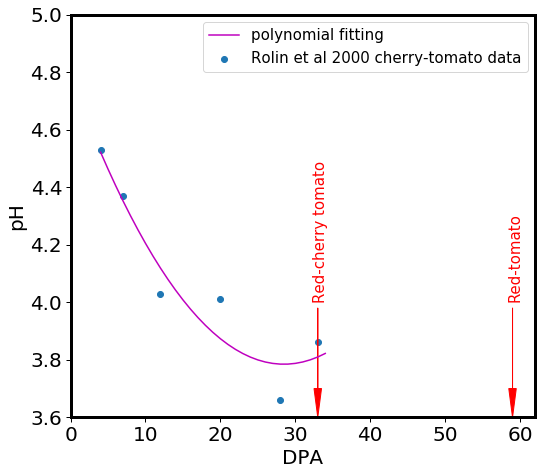

In [12]:
from pandas import DataFrame
d = {"DPA":[4,7,12,20,28,33],"pH":[4.53,4.37,4.03,4.01,3.66,3.86]}
pd = DataFrame(data = d)

import numpy as np
p = np.polyfit(d["DPA"],d["pH"],2)
q = np.poly1d(p)
#print(p)

x1=list()
y1=list()
y2=list()
for i in range(4,35):
    x1.append(i)
    y2.append(q(i))

    
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'font.size': 20}) #sets a global fontsize
plt.rcParams['xtick.major.size'] = 5 # adjusts tick line length and width
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['axes.linewidth']=3 # makes axes line thicker
plt.figure(figsize=(8,7))

plt.scatter(d["DPA"],d["pH"],label="Rolin et al 2000 cherry-tomato data")
plt.plot(x1,y2,label="polynomial fitting",color="m")
plt.text(32.3,4.45,"Red-cherry tomato",fontsize=15,color="r",rotation=90)
plt.arrow(33,3.98,0,-0.28,head_width=1,head_length=0.1,color="r")
plt.text(58.3,4.27,"Red-tomato",fontsize=15,color="r",rotation=90)
plt.arrow(59,3.98,0,-0.28,head_width=1,head_length=0.1,color="r")
plt.xlim(0,62)
plt.ylim(3.6,5.0)
plt.ylabel("pH")
plt.xlabel("DPA")
plt.legend(fontsize="15")
plt.tight_layout()
plt.show()


VacpH = dict()
compH = dict()
i=1
for x in DPA[1:]:
    VacpH[x]=round(q(x),1)
    compH["v"+str(i)]=round(q(x),1)
    i=i+1

Linear transformation of cherry tomato data to estiamte tomato DPA

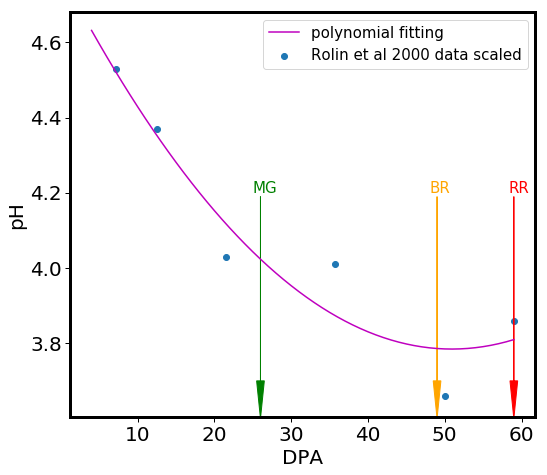

In [13]:
from pandas import DataFrame
d = {"DPA":[4,7,12,20,28,33],"pH":[4.53,4.37,4.03,4.01,3.66,3.86]}
d2 = {"DPA":[4,7,12,20,28,33],"pH":[4.53,4.37,4.03,4.01,3.66,3.86]}
for x in range(0,len(d["DPA"])):
    d2["DPA"][x]=round(d["DPA"][x]*(59.0/33),2)

pd = DataFrame(data = d2)

import numpy as np
p = np.polyfit(d2["DPA"],d2["pH"],2)
q = np.poly1d(p)

x1=list()
y1=list()
y2=list()
for i in range(4,60):
    x1.append(i)
    y2.append(q(i))

    
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'font.size': 20}) #sets a global fontsize
plt.rcParams['xtick.major.size'] = 5 # adjusts tick line length and width
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['axes.linewidth']=3 # makes axes line thicker
plt.figure(figsize=(8,7))

plt.scatter(d2["DPA"],d2["pH"],label="Rolin et al 2000 data scaled")
plt.plot(x1,y2,label="polynomial fitting",color="m")
plt.text(25,4.2,"MG",fontsize=15,color="g")
plt.arrow(26,4.19,0,-0.49,head_width=1,head_length=0.1,color="g")
plt.text(48,4.2,"BR",fontsize=15,color="orange")
plt.arrow(49,4.19,0,-0.49,head_width=1,head_length=0.1,color="orange")
plt.text(58.3,4.2,"RR",fontsize=15,color="r")
plt.arrow(59,4.19,0,-0.49,head_width=1,head_length=0.1,color="r")
plt.ylabel("pH")
plt.xlabel("DPA")
plt.legend(fontsize="15",loc="best")
plt.tight_layout()
plt.show()


VacpH = dict()
compH = dict()
i=1
for x in DPA[1:]:
    VacpH[x]=round(q(x),1)
    compH["v"+str(i)]=round(q(x),1)
    i=i+1
#d

### Setting up final biomass before updating vacuolar pH

In [14]:

AA_b = ["GLN","ASN","SER","GLY","THR","L_ALPHA_ALANINE","4_AMINO_BUTYRATE","VAL","ILE","PHE","LEU","LYS","ARG","L_ASPARTATE","GLT","HIS","MET","PRO","TRP","TYR","CYS"]

for m in AA_b:
    met = Metabolite(m+"_b10")
    met.compartment = "b10"
    met.name = cobra_model2.metabolites.get_by_id(m+"_c10").name
    met.formula = cobra_model2.metabolites.get_by_id(m+"_c10").formula
    met.notes = cobra_model2.metabolites.get_by_id(m+"_c10").notes
    met.charge = cobra_model2.metabolites.get_by_id(m+"_c10").charge
    rxn = Reaction("Biomass_"+m+"_c_tx10")
    rxn.name="Biomass "+m+" _c accumulation"
    cobra_model2.add_reaction(rxn)
    rxn.add_metabolites({cobra_model2.metabolites.get_by_id(m+"_c10"):-1,met:1})
    rxn.lower_bound = 0
    rxn.upper_bound = 1000
    
    rxn = Reaction("Biomass_"+m+"_v_tx10")
    rxn.name="Biomass "+m+" _v accumulation"
    cobra_model2.add_reaction(rxn)
    if m == "HIS":
        rxn.add_metabolites({cobra_model2.metabolites.get_by_id("b"+m+"_v10"):-1,met:1})
    else:
        rxn.add_metabolites({cobra_model2.metabolites.get_by_id(m+"_v10"):-1,met:1})
    rxn.lower_bound = 0
    rxn.upper_bound = 1000
    
    
OA = ["CIT","MAL","FUM"]
for m in OA:
    met = Metabolite(m+"_b10")
    met.compartment = "b10"
    met.name = cobra_model2.metabolites.get_by_id(m+"_c10").name
    met.formula = cobra_model2.metabolites.get_by_id(m+"_c10").formula
    met.notes = cobra_model2.metabolites.get_by_id(m+"_c10").notes
    met.charge = cobra_model2.metabolites.get_by_id(m+"_c10").charge
    rxn = Reaction("Biomass_"+m+"_c_tx10")
    rxn.name="Biomass "+m+" _c accumulation"
    cobra_model2.add_reaction(rxn)
    rxn.add_metabolites({cobra_model2.metabolites.get_by_id(m+"_c10"):-1,met:1})
    rxn.lower_bound = 0
    rxn.upper_bound = 1000
    
    rxn = Reaction("Biomass_"+m+"_v_tx10")
    rxn.name="Biomass "+m+" _v accumulation"
    cobra_model2.add_reaction(rxn)
    rxn.add_metabolites({cobra_model2.metabolites.get_by_id(m+"_v10"):-1,met:1})
    rxn.lower_bound = 0
    rxn.upper_bound = 1000


Sugars = ["GLC","FRU","SUCROSE"]
for m in Sugars:
    met = Metabolite(m+"_b10")
    met.compartment = "b10"
    met.name = cobra_model2.metabolites.get_by_id(m+"_c10").name
    met.formula = cobra_model2.metabolites.get_by_id(m+"_c10").formula
    met.notes = cobra_model2.metabolites.get_by_id(m+"_c10").notes
    met.charge = cobra_model2.metabolites.get_by_id(m+"_c10").charge
    rxn = Reaction("Biomass_"+m+"_c_tx10")
    rxn.name="Biomass "+m+" _c accumulation"
    cobra_model2.add_reaction(rxn)
    rxn.add_metabolites({cobra_model2.metabolites.get_by_id(m+"_c10"):-1,met:1})
    rxn.lower_bound = 0
    rxn.upper_bound = 1000
    
    rxn = Reaction("Biomass_"+m+"_v_tx10")
    rxn.name="Biomass "+m+" _v accumulation"
    cobra_model2.add_reaction(rxn)
    rxn.add_metabolites({cobra_model2.metabolites.get_by_id(m+"_v10"):-1,met:1})
    rxn.lower_bound = 0
    rxn.upper_bound = 1000
    #######
    #rxn = Reaction("HYPO_biomass"+m)
    #rxn.add_metabolites({met:-1})
    #rxn.lower_bound = 0
    #rxn.upper_bound = 10
    #cobra_model2.add_reaction(rxn)




rxn = Reaction("Final_Biomass_tx")
rxn.name = "Final Fruit Biomass"
for k in Conc.keys():
    if k=="AA":
        for i in AA_b:
            rxn.add_metabolites({cobra_model2.metabolites.get_by_id(i+"_b10"):-float(Conc.get(k)[10])/scale})
    elif k=="Protein":
        continue
    elif k=="NA":
        continue
    else:
        if k=="STARCH":
            rxn.add_metabolites({cobra_model2.metabolites.get_by_id("Starch_b10"):-float(Conc.get(k)[10])/scale})
        elif k=="CELLULOSE":
            continue
        elif k=="PALMITATE":
            continue
        #elif k=="FUM":
        #    continue
        #elif k=="Pi":
        #    continue
        else:
            rxn.add_metabolites({cobra_model2.metabolites.get_by_id(k+"_b10"):-float(Conc.get(k)[10])/scale})

rxn.lower_bound = 0
rxn.upper_bound = 1000
cobra_model2.add_reaction(rxn)

for i in range(1,11):
    rxn = Reaction("Protein_biomass_demand_tx"+str(i))
    rxn.name = "Protein in Biomass "+str(i)
    k="Protein"
    rxn.add_metabolites({cobra_model2.metabolites.get_by_id("PROTEIN_b"+str(i)):-1})
    rxn.lower_bound = 0
    rxn.upper_bound = 1000
    cobra_model2.add_reaction(rxn)

rxn = Reaction("Final_DNARNA_tx")
rxn.name = "Final NA in Biomass"
k="NA"
rxn.add_metabolites({cobra_model2.metabolites.get_by_id("RNA_b10"):-1,cobra_model2.metabolites.get_by_id("DNA_b10"):-1})
rxn.lower_bound = 0#float(Conc.get(k)[10])/scale
rxn.upper_bound = 0#float(Conc.get(k)[10])/scale
cobra_model2.add_reaction(rxn)


for i in range(10,11):
    rxn = Reaction("NITRATE_biomass"+str(i))
    rxn.add_metabolites({cobra_model2.metabolites.get_by_id("NITRATE_v"+str(i)):-1})
    rxn.lower_bound = 0
    rxn.upper_bound = 1000
    cobra_model2.add_reaction(rxn)
    rxn = Reaction("MAL_biomass"+str(i))
    rxn.add_metabolites({cobra_model2.metabolites.get_by_id("MAL_v"+str(i)):-1})
    rxn.lower_bound = 0
    rxn.upper_bound = 1000
    cobra_model2.add_reaction(rxn)
    rxn = Reaction("CIT_biomass"+str(i))
    rxn.add_metabolites({cobra_model2.metabolites.get_by_id("CIT_v"+str(i)):-1})
    rxn.lower_bound = 0
    rxn.upper_bound = 1000
    cobra_model2.add_reaction(rxn)
    for met in ["CAII","KI","MGII","NITRATE"]:
        rxn = Reaction(met+"_biomass_c"+str(i))
        rxn.add_metabolites({cobra_model2.metabolites.get_by_id(met+"_c"+str(i)):-1})
        rxn.lower_bound = 0
        rxn.upper_bound = 1000
        cobra_model2.add_reaction(rxn)




In [15]:
chargedFruit = convertToFractionalChargesFruit(cobra_model2,infile="MetaboliteChargedStates.xlsx",compH=compH)
chargedFruit.reactions.get_by_id("Final_Biomass_tx").objective_coefficient=1
del(cobra_model2)

In [16]:
chargedFruit.reactions.Phloem_uptake_tx1.reaction

'0.9603960396 PROTON_e1 --> 0.0022970297 4_AMINO_BUTYRATE_c1 + 0.0004186704 ARG_c1 + 0.0015049505 ASN_c1 + 0.0004186704 CYS_c1 + 0.0792079208 FRU_c1 + 0.0693069307 GLC_c1 + 0.0240792079 GLN_c1 + 0.0124356436 GLT_c1 + 0.0007128713 GLY_c1 + 0.0004186704 HIS_c1 + 0.0017425743 ILE_c1 + 0.0020594059 LEU_c1 + 0.0022178218 LYS_c1 + 0.0038811881 L_ALPHA_ALANINE_c1 + 0.006019802 L_ASPARTATE_c1 + 0.0004186704 MET_c1 + 0.0057029703 PHE_c1 + 0.9603960396 PROTON_c1 + 0.0004186704 PRO_c1 + 0.003960396 SER_c1 + 0.7326732673 SUCROSE_c1 + 0.0068910891 THR_c1 + 0.0004186704 TRP_c1 + 0.0004186704 TYR_c1 + 0.0027722772 VAL_c1'

In [17]:
#removed LEU and TRP from phloem because degradation pathway is incomplete and their fraction in 
# phloem is extremely minor
for Met in ["LEU_c","TRP_c","VAL_c","ILE_c","PHE_c","4_AMINO_BUTYRATE_c","TYR_c","GLN_c"]:
    for i in range(1,11):
        met = chargedFruit.metabolites.get_by_id(Met+str(i))
        coeff = chargedFruit.reactions.get_by_id("Phloem_uptake_tx"+str(i)).metabolites.get(met)
        chargedFruit.reactions.get_by_id("Phloem_uptake_tx"+str(i)).add_metabolites({met:-1*coeff})

sol = chargedFruit.optimize()
sol.fluxes.get("Final_Biomass_tx")

233.65614542592633

### Constraining cellulose demand flux based on increasing cell volume

In [18]:
from studyFunctions import celluloseDemandFlux

cobra_model2 = chargedFruit.copy()
print("Constraining cellulose demand flux...")


for i in range(1,11):
    rxn = Reaction("CELLULOSE_accumulation"+str(i))
    met = cobra_model2.metabolites.get_by_id("CELLULOSE_c"+str(i))
    rxn.add_metabolites({met:-1})
    rxn.lower_bound = celluloseDemandFlux(DPA[i],Ncells = 25*(10**6),unit_time=unit_time)
    rxn.upper_bound = celluloseDemandFlux(DPA[i],Ncells = 25*(10**6),unit_time=unit_time)
    cobra_model2.add_reaction(rxn)


Constraining cellulose demand flux...


### Constraining palmitate demand flux based on increasing cell volume


In [19]:
from studyFunctions import phospholipidDemandFlux

print("Constraining phospholipid demand flux...")

for i in range(1,11):
    rxn = Reaction("phospholipid_accumulation"+str(i))
    met = cobra_model2.metabolites.get_by_id("L_1_PHOSPHATIDYL_ETHANOLAMINE_r"+str(i))
    rxn.add_metabolites({met:-0.273})
    met = cobra_model2.metabolites.get_by_id("PHOSPHATIDYL_CHOLINE_r"+str(i))
    rxn.add_metabolites({met:-0.353})
    met = cobra_model2.metabolites.get_by_id("L_PHOSPHATIDATE_p"+str(i))
    rxn.add_metabolites({met:-0.374})
    rxn.lower_bound = float(phospholipidDemandFlux(DPA[i],Ncells = 25*(10**6),unit_time=unit_time,scaling_factor=100.0/8.512820512820287))
    rxn.upper_bound = float(phospholipidDemandFlux(DPA[i],Ncells = 25*(10**6),unit_time=unit_time,scaling_factor=100.0/8.512820512820287))
    cobra_model2.add_reaction(rxn)

Constraining phospholipid demand flux...


In [20]:
sol = cobra_model2.optimize()
sol.fluxes.get("Final_Biomass_tx")

233.65614542592633

### Constraining protein demand flux based on increasing cell volume


In [21]:
ProtConc=21458.1747597         #Biais data
#ProtConc=19659.7704473         #Jose's data

In [22]:
from studyFunctions import estimateProteinDemandFlux

print("Constraining protein demand flux...")
#cobra_model2 = temp_model.copy()
for i in range(1,11):
    rxn = cobra_model2.reactions.get_by_id("Protein_biomass_demand_tx"+str(i))
    print(estimateProteinDemandFlux(DPA[i],ProtConc=21458.1747597,unit_time=unit_time,Ncell = 25*(10**6)))
    temp_A = estimateProteinDemandFlux(DPA[i],ProtConc=21458.1747597,unit_time=unit_time,Ncell = 25*(10**6))
    rxn.lower_bound = temp_A
    rxn.upper_bound = temp_A
    



Constraining protein demand flux...
0.0112816633773
0.0174385732478
0.0259973905035
0.030016941082
0.0237650500464
0.013162547312
0.00567001934018
0.00208064699906
0.000668913450129
0.000176835351992


In [23]:
sol = cobra_model2.optimize()
print(sol.fluxes.get("Final_Biomass_tx"))

2.64816625885


### Phytol and Lycopene data

In [24]:
#constraining pigment accumulation/degradation rates
for i in range(1,11):
    rxn = Reaction("Lycopene_biomass_demand_tx"+str(i))
    rxn.add_metabolites({cobra_model2.metabolites.get_by_id("CPD1F_114_p"+str(i)):-1})
    rxn.lower_bound = float(estimateLycopeneDemand(DPA[i],unit_time)*0.001)    #mmol/fruit/5.1day
    rxn.upper_bound = float(estimateLycopeneDemand(DPA[i],unit_time)*0.001)    #mmol/fruit/5.1day
    #print(rxn.reaction)
    print(rxn.lower_bound)
    cobra_model2.add_reaction(rxn)
    
    rxn = Reaction("Phytol_biomass_demand_tx"+str(i))
    rxn.add_metabolites({cobra_model2.metabolites.get_by_id("PHYTOL_p"+str(i)):-1})
    rxn.lower_bound = float(estimatePhytolDemand(DPA[i],unit_time)*0.001)         #mmol/fruit/5.1day
    rxn.upper_bound = float(estimatePhytolDemand(DPA[i],unit_time)*0.001)         #mmol/fruit/5.1day
    #print rxn.lower_bound
    cobra_model2.add_reaction(rxn)

2.49659137808e-12
9.47693877151e-10
8.15478226563e-08
2.8662259526e-06
5.49617628915e-05
0.000632356115311
0.00308416828079
0.0031979747548
0.000873216062261
0.000160538104002


In [25]:
sol=cobra_model2.optimize()
print(sol.fluxes.get("Final_Biomass_tx"))

2.64118412229


### checkpoint : create backup

In [26]:
backup2 =  cobra_model2.copy()

### Add osmotic constraint to fruit model


In [27]:
cobra_model2 = backup2.copy()


vacMets=["SUCROSE_v","MAL_v","NITRATE_v","AMMONIUM_v","CIT_v","GLN_v","ASN_v","SER_v","GLY_v","THR_v","L_ALPHA_ALANINE_v","4_AMINO_BUTYRATE_v","VAL_v","ILE_v","PHE_v","LEU_v","LYS_v","ARG_v","L_ASPARTATE_v","GLT_v","bHIS_v","MET_v","PRO_v","TRP_v","TYR_v","CYS_v","GLC_v","FRU_v","FUM_v","MGII_v","KI_v","CAII_v"]


#Add water potential constraint on the whole cell
for i in range(1,10):
    met1_v = Metabolite("VO_"+str(i))
    met1_v.name = "vacuolar osmolarity pseudo metabolite"
    met1_c = Metabolite("CO_"+str(i))
    met1_c.name = "cytosolic osmolarity pseudo metabolite"
    met2_c = Metabolite("CC_c"+str(i))
    met2_c.name = "cytosolic_charge_constraint"
    met2_c.compartment="c"+str(i)
    met2_v = Metabolite("CC_v"+str(i))
    met2_v.name = "vacuolar_charge_constraint"
    met2_v.compartment="v"+str(i)
    for metID in vacMets:
        met = cobra_model2.metabolites.get_by_id(metID+str(i))
        rxn = cobra_model2.reactions.get_by_id(metID+"_Transfer"+str(i)+str(i+1))
        charge = 0
        for Reac in rxn.reactants:
            if Reac.id.__contains__("PROTON"):
                continue
            charge = charge + (rxn.metabolites.get(Reac)*int(Reac.charge)*-1)
        rxn.add_metabolites({met1_v:1,met2_v:charge})
    for rxn in cobra_model2.reactions.query("_c_Transfer"+str(i)+str(i+1)):
        charge = 0
        for Reac in rxn.reactants:
            if Reac.id.__contains__("PROTON"):
                continue
            charge = charge + (rxn.metabolites.get(Reac)*int(Reac.charge)*-1)
        rxn.add_metabolites({met1_c:1,met2_c:charge})




#Set constraints for final fruit biomass
met1_v = Metabolite("VO_10")
met1_v.name = "vacuolar osmolarity pseudo metabolite"
met1_c = Metabolite("CO_10")
met1_c.name = "cytosolic osmolarity pseudo metabolite"
met2_c = Metabolite("CC_c10")
met2_c.name = "cytosolic_charge_constraint"
met2_c.compartment="c10"
met2_v = Metabolite("CC_v10")
met2_v.name = "vacuolar_charge_constraint"
met2_v.compartment="v10"

VO_10 = 0
CO_10 = 0
CC_c10 = 0
CC_v10 = 0

AA_b = ["GLN","ASN","SER","GLY","THR","L_ALPHA_ALANINE","4_AMINO_BUTYRATE","VAL","ILE","PHE","LEU","LYS","ARG","L_ASPARTATE","GLT","HIS","MET","PRO","TRP","TYR","CYS"]

for m in AA_b:
    met = cobra_model2.metabolites.get_by_id(m+"_c10")
    rxn = cobra_model2.reactions.get_by_id("Biomass_"+m+"_c_tx10")
    charge = 0
    stoich = 0
    for Reac in rxn.reactants:
        if Reac.id.__contains__("PROTON"):
            continue
        charge = charge + (rxn.metabolites.get(Reac)*int(Reac.charge)*-1)
        stoich = stoich + (rxn.metabolites.get(Reac)*-1)
    rxn.add_metabolites({met1_c:stoich,met2_c:charge})
    met = cobra_model2.metabolites.get_by_id(m+"_v10")
    rxn = cobra_model2.reactions.get_by_id("Biomass_"+m+"_v_tx10")
    charge = 0
    stoich = 0
    for Reac in rxn.reactants:
        if Reac.id.__contains__("PROTON"):
            continue
        charge = charge + (rxn.metabolites.get(Reac)*int(Reac.charge)*-1)
        stoich = stoich + (rxn.metabolites.get(Reac)*-1)
    rxn.add_metabolites({met1_v:stoich,met2_v:charge})

    
OA = ["CIT","MAL"]

for m in OA:
    met = cobra_model2.metabolites.get_by_id(m+"_c10")
    rxn = cobra_model2.reactions.get_by_id("Biomass_"+m+"_c_tx10")
    charge = 0
    stoich = 0
    for Reac in rxn.reactants:
        if Reac.id.__contains__("PROTON"):
            continue
        charge = charge + (rxn.metabolites.get(Reac)*int(Reac.charge)*-1)
        stoich = stoich + (rxn.metabolites.get(Reac)*-1)
    rxn.add_metabolites({met1_c:stoich,met2_c:charge})
    met = cobra_model2.metabolites.get_by_id(m+"_v10")
    rxn = cobra_model2.reactions.get_by_id("Biomass_"+m+"_v_tx10")
    charge = 0
    stoich = 0
    for Reac in rxn.reactants:
        if Reac.id.__contains__("PROTON"):
            continue
        charge = charge + (rxn.metabolites.get(Reac)*int(Reac.charge)*-1)
        stoich = stoich + (rxn.metabolites.get(Reac)*-1)
    rxn.add_metabolites({met1_v:stoich,met2_v:charge})

Sugars = ["GLC","FRU","SUCROSE"]

for m in Sugars:
    met = cobra_model2.metabolites.get_by_id(m+"_c10")
    rxn = cobra_model2.reactions.get_by_id("Biomass_"+m+"_c_tx10")
    charge = 0
    stoich = 0
    for Reac in rxn.reactants:
        if Reac.id.__contains__("PROTON"):
            continue
        charge = charge + (rxn.metabolites.get(Reac)*int(Reac.charge)*-1)
        stoich = stoich + (rxn.metabolites.get(Reac)*-1)
    rxn.add_metabolites({met1_c:stoich,met2_c:charge})
    met = cobra_model2.metabolites.get_by_id(m+"_v10")
    rxn = cobra_model2.reactions.get_by_id("Biomass_"+m+"_v_tx10")
    charge = 0
    stoich = 0
    for Reac in rxn.reactants:
        if Reac.id.__contains__("PROTON"):
            continue
        charge = charge + (rxn.metabolites.get(Reac)*int(Reac.charge)*-1)
        stoich = stoich + (rxn.metabolites.get(Reac)*-1)
    rxn.add_metabolites({met1_v:stoich,met2_v:charge})


#
rxn = cobra_model2.reactions.get_by_id("Ca_biomass10")
rxn.add_metabolites({met1_v:1,met2_v:2})
rxn = cobra_model2.reactions.get_by_id("Mg_biomass10")
rxn.add_metabolites({met1_v:1,met2_v:2})
rxn = cobra_model2.reactions.get_by_id("K_biomass10")
rxn.add_metabolites({met1_v:1,met2_v:1})
rxn = cobra_model2.reactions.get_by_id("NITRATE_biomass10")
rxn.add_metabolites({met1_v:1,met2_v:-1})
rxn = cobra_model2.reactions.get_by_id("CAII_biomass_c10")
rxn.add_metabolites({met1_c:1,met2_c:2})
rxn = cobra_model2.reactions.get_by_id("MGII_biomass_c10")
rxn.add_metabolites({met1_c:1,met2_c:2})
rxn = cobra_model2.reactions.get_by_id("KI_biomass_c10")
rxn.add_metabolites({met1_c:1,met2_c:1})
rxn = cobra_model2.reactions.get_by_id("NITRATE_biomass_c10")
rxn.add_metabolites({met1_c:1,met2_c:-1})


import math
#Set total(met1_v) = (volume_of_vacuole/volume_of_cytosol) * total(met1_c)
for i in range(1,11):
    Vv = 0.853*(1-(math.e**((-2293-(DPA[i]*24*60))/10633)))
    Vc = (0.933 - Vv)/1.13
    #print(Vv/Vc)
    met = Metabolite("WCO_"+str(i))
    met.name = "Whole cell osmolarity psuedo metabolite"
    met1_v = cobra_model2.metabolites.get_by_id("VO_"+str(i))
    met1_c = cobra_model2.metabolites.get_by_id("CO_"+str(i))
    rxn =Reaction("IntercellularWaterPotentialConstraint"+str(i))
    rxn.add_metabolites({met1_c:-1,met1_v:-1*(Vv/Vc),met:1+(Vv/Vc)})
    rxn.lower_bound = 0
    rxn.upper_bound = 1000
    cobra_model2.add_reaction(rxn)

        
#Set sum(van't_Hoff_factor*number_of_moles) = cell_volume*Osmolarity
import math
C_cell = 275           #Almeida and Huber 1999; units = mOsmol/kg ~ mmol/L
C_cell = 275000        #units = mmol/m3
for i in range(1,11):
    met = cobra_model2.metabolites.get_by_id("WCO_"+str(i))
    V_pericarp = estimateVpericarp(DPA[i],hollow=False)
    rxn = Reaction("WCOsetter_tx"+str(i))
    rxn.name = "WCO_setter"
    rxn.add_metabolites({met:-1})
    rxn.lower_bound = round(V_pericarp*C_cell,3)
    rxn.upper_bound = round(V_pericarp*C_cell,3)
    cobra_model2.add_reaction(rxn)



In [28]:
sol=cobra_model2.optimize()
print(sol.fluxes.get("Final_Biomass_tx"))

### Accounting for NGAM  based on maintenance respiration in Walker and Thornley 1997



In [29]:
mR ={387:0.052,931:0.021,1591:0.015,2402:0.007}
for i in mR.keys():
    print("==========")
    print("mass ="+str(i))
    print("relative r="+str(mR[i]))
    print("mg/day ="+str(mR[i]*i))
    print("mmol/day ="+str(mR[i]*i/12))
    print("mmol/day ="+str(mR[i]*i*unit_time/12))

mass =2402
relative r=0.007
mg/day =16.814
mmol/day =1.40116666667
mmol/day =7.14595
mass =387
relative r=0.052
mg/day =20.124
mmol/day =1.677
mmol/day =8.5527
mass =931
relative r=0.021
mg/day =19.551
mmol/day =1.62925
mmol/day =8.309175
mass =1591
relative r=0.015
mg/day =23.865
mmol/day =1.98875
mmol/day =10.142625


    This maitenance respiration is reported in relative respiration units. Converting them into mg/day, mmol/day and mmol/5.1 days:
    ================================================================================
    Mean fruit mass       1/day        mg/day          mmol/day         mmol/5.1days
    ================================================================================
      387                0.052          20.124           1.677             8.553
      931                0.021          19.551           1.629             8.308
     1591                0.015          23.865           1.989            10.144
     2402                0.007          16.814           1.401             7.145
    ================================================================================

In [30]:
meanRes = (8.553+8.308+10.144+7.145)/4
print(meanRes)

8.5375


    Using core model ATPase NGAM flux of 26.2 mmol/fruit/5.1 days was estimated to correspond with a respiration rate of 8.5375 mmol CO2/fruit/5.1

In [31]:
ATPase = 26.2

In [32]:
for i in range(1,11):
    met=Metabolite("ATPNAPDH_maintenance_constraint_"+str(i))
    cobra_model2.reactions.get_by_id("ATPase_tx"+str(i)).add_metabolites({met:-1})
    cobra_model2.reactions.get_by_id("NADPHoxc_tx"+str(i)).add_metabolites({met:3})
    cobra_model2.reactions.get_by_id("NADPHoxp_tx"+str(i)).add_metabolites({met:3})
    cobra_model2.reactions.get_by_id("NADPHoxm_tx"+str(i)).add_metabolites({met:3})
    cobra_model2.reactions.get_by_id("ATPase_tx"+str(i)).lower_bound = ATPase
    cobra_model2.reactions.get_by_id("ATPase_tx"+str(i)).upper_bound = ATPase


In [33]:
backup4 = cobra_model2.copy()
sol =backup4.optimize()
print(sol.fluxes.get("Final_Biomass_tx"))

<Solution 1.103 at 0x7f292395e190>

### Constraining phloem uptake rate

In [34]:

cobra_model2 = backup4.copy()
C=0
for met in cobra_model2.reactions.get_by_id("Phloem_uptake_tx1").metabolites.keys():
    if met.formula == "" or met.formula == "NA" or not "C" in met.formula:
        continue
    C=C+(int(met.formula.split("H")[0].split("C")[1])*cobra_model2.reactions.get_by_id("Phloem_uptake_tx1").metabolites.get(met))

print("Total C in 1 mol of phloem = "+str(abs(C)))
print("-------------")

for i in range(1,11):
    Ccont = estimateCcontent(DPA[i])
    cobra_model2.reactions.get_by_id("Phloem_uptake_tx"+str(i)).upper_bound = estimatePhloemUptakeConstraint(Ccont)*24*(unit_time/abs(C*12))
    print "Cuptake rate = "+str(estimatePhloemUptakeConstraint(Ccont)*24*(unit_time/abs(C*12)))


Total C in 1 mol of phloem = 9.8517340867
-------------
Cuptake rate = 10.3246788549
Cuptake rate = 9.85705699494
Cuptake rate = 7.10505745832
Cuptake rate = 4.09152557633
Cuptake rate = 3.17570829047
Cuptake rate = 2.97194127161
Cuptake rate = 2.92189127324
Cuptake rate = 2.90765364888
Cuptake rate = 2.90304441179
Cuptake rate = 2.90138312454


### g) Run basic simulation

In [35]:
for i in range(1,10):
    rxn = cobra_model2.reactions.get_by_id("FUM_c_Transfer"+str(i)+str(i+1))
    rxn.lower_bound = rxn.upper_bound = 0
    rxn = cobra_model2.reactions.get_by_id("FUM_v_Transfer"+str(i)+str(i+1))
    rxn.lower_bound = rxn.upper_bound = 0
    #set Lycopene and Phytol demand to 0
    rxn = cobra_model2.reactions.get_by_id("Lycopene_biomass_demand_tx"+str(i))
    rxn.lower_bound = 0
    rxn.upper_bound = 0
    rxn = Reaction("Phytol_biomass_demand_tx"+str(i))
    rxn.lower_bound = 0
    rxn.upper_bound = 0



In [36]:
weightings =dict()
for rxn in cobra_model2.reactions:
    if rxn.id.__contains__("Transfer"):
        weightings[rxn.id]=1
    elif rxn.id.__contains__("Photon_") or rxn.id.startswith("H_") or rxn.id.__contains__("H2O_") or rxn.id.__contains__("O2_") or rxn.id.__contains__("CO2_"):
        weightings[rxn.id]=1
    else:
        weightings[rxn.id]=1

In [37]:
import time
print(time.ctime())
cobra_model2.reactions.get_by_id("Final_Biomass_tx").objective_coefficient=1
#solution2 = flux_analysis.parsimonious.pfba(cobra_model2)
solution = pfba_Weighted(cobra_model2,weightings)
print(time.ctime())

Mon Aug 12 10:18:33 2019
Mon Aug 12 10:18:53 2019


### Fruit final biomass

In [38]:
print("Final fruit biomass accumulation flux for model with osmolarity constraint = "+str(solution.fluxes["Final_Biomass_tx"]))


Final fruit biomass accumulation flux for model with osmolarity constraint = 1.1026173081545576


### Export model

In [39]:
temp_model = cobra_model2.copy()
for met in temp_model.metabolites:
    if met.charge != None:
        met.charge = int(met.charge)
io.sbml.write_cobra_model_to_sbml_file(temp_model,"ConstrainedFruitModel.xml",use_fbc_package=False)
del(temp_model)

### Write flux distribution to file

In [70]:
writeSolutionFluxesToFile(solution2,"FruitFluxes.csv",cobra_model2)